In [ ]:
pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download thomasdubail/brain-tumors-256x256

Dataset URL: https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256
License(s): CC0-1.0


In [ ]:
! unzip brain-tumors-256x256.zip

Archive:  brain-tumors-256x256.zip
  inflating: Data/glioma_tumor/G_1.jpg  
  inflating: Data/glioma_tumor/G_10.jpg  
  inflating: Data/glioma_tumor/G_100.jpg  
  inflating: Data/glioma_tumor/G_101.jpg  
  inflating: Data/glioma_tumor/G_102.jpg  
  inflating: Data/glioma_tumor/G_103.jpg  
  inflating: Data/glioma_tumor/G_104.jpg  
  inflating: Data/glioma_tumor/G_105.jpg  
  inflating: Data/glioma_tumor/G_106.jpg  
  inflating: Data/glioma_tumor/G_107.jpg  
  inflating: Data/glioma_tumor/G_108.jpg  
  inflating: Data/glioma_tumor/G_109.jpg  
  inflating: Data/glioma_tumor/G_11.jpg  
  inflating: Data/glioma_tumor/G_110.jpg  
  inflating: Data/glioma_tumor/G_111.jpg  
  inflating: Data/glioma_tumor/G_112.jpg  
  inflating: Data/glioma_tumor/G_113.jpg  
  inflating: Data/glioma_tumor/G_114.jpg  
  inflating: Data/glioma_tumor/G_115.jpg  
  inflating: Data/glioma_tumor/G_116.jpg  
  inflating: Data/glioma_tumor/G_117.jpg  
  inflating: Data/glioma_tumor/G_118.jpg  
  inflating: Data/gliom

In [ ]:
import os
import shutil
import random

# Set seed for reproducibility
random.seed(42)

# Paths
source_dir = '/content/Data'
base_dir = '/content/output'  # Output folder
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Create output directories
for split_dir in [train_dir, test_dir]:
    for category in ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']:
        os.makedirs(os.path.join(split_dir, category), exist_ok=True)

# Split function
def split_data(source, train_dest, test_dest, split_ratio=0.8):
    files = [f for f in os.listdir(source) if f.endswith('.jpg')]
    random.shuffle(files)

    split_point = int(len(files) * split_ratio)
    train_files = files[:split_point]
    test_files = files[split_point:]

    for file_list, dest_dir in [(train_files, train_dest), (test_files, test_dest)]:
        for fname in file_list:
            src_path = os.path.join(source, fname)
            dst_path = os.path.join(dest_dir, fname)
            try:
                shutil.copyfile(src_path, dst_path)
            except:
                pass  # Ignore corrupted images

# Split cats and dogs
split_data(os.path.join(source_dir, 'glioma_tumor'),
           os.path.join(train_dir, 'glioma_tumor'),
           os.path.join(test_dir, 'glioma_tumor'))

split_data(os.path.join(source_dir, 'meningioma_tumor'),
           os.path.join(train_dir, 'meningioma_tumor'),
           os.path.join(test_dir, 'meningioma_tumor'))

split_data(os.path.join(source_dir, 'normal'),
           os.path.join(train_dir, 'normal'),
           os.path.join(test_dir, 'normal'))

split_data(os.path.join(source_dir, 'pituitary_tumor'),
           os.path.join(train_dir, 'pituitary_tumor'),
           os.path.join(test_dir, 'pituitary_tumor'))

In [ ]:
import os

# Count number of images in each set
for split in ['train', 'test']:
    print(f"\n{split.upper()} SET:")
    for category in ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']:
        folder_path = f"/content/output/{split}/{category}"
        count = len(os.listdir(folder_path))
        print(f"  {category}: {count} images")



TRAIN SET:
  glioma_tumor: 720 images
  meningioma_tumor: 730 images
  normal: 350 images
  pituitary_tumor: 675 images

TEST SET:
  glioma_tumor: 181 images
  meningioma_tumor: 183 images
  normal: 88 images
  pituitary_tumor: 169 images


In [ ]:
 from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(256, 256, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # For 4 classes
])

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,078,212 (225.37 MB)

 Trainable params: 59,078,212 (225.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
#     layers.MaxPooling2D(2, 2),
#         Dropout(0.25),


#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D(2, 2),
#         Dropout(0.25),


#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D(2, 2),
#         Dropout(0.25),


#     layers.Flatten(),
#     layers.Dense(512, activation='relu'),
#         Dropout(0.5),
#     layers.Dense(4, activation='softmax')  # Change to softmax if more than two classes
# ])

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for multi-class
#               metrics=['accuracy'])

# model.summary()

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/output/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'  # or 'categorical' for multi-class classification
)

validation_generator = test_datagen.flow_from_directory(
    '/content/output/test',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)


Found 2475 images belonging to 4 classes.
Found 621 images belonging to 4 classes.


In [ ]:
import math # import math module
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / train_generator.batch_size), # use batch_size from train_generator
    epochs=20,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples / validation_generator.batch_size), # use batch_size from validation_generator
    callbacks=[early_stop, reduce_lr]
)



Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 47s 608ms/step - accuracy: 0.2999 - loss: 2.2407 - val_accuracy: 0.3060 - val_loss: 1.7094 - learning_rate: 0.0010
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 38s 487ms/step - accuracy: 0.3259 - loss: 1.6525 - val_accuracy: 0.3124 - val_loss: 1.5342 - learning_rate: 0.0010
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 39s 495ms/step - accuracy: 0.3695 - loss: 1.4576 - val_accuracy: 0.4155 - val_loss: 1.3982 - learning_rate: 0.0010
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 39s 501ms/step - accuracy: 0.3974 - loss: 1.3880 - val_accuracy: 0.4316 - val_loss: 1.3422 - learning_rate: 0.0010
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 38s 493ms/step - accuracy: 0.3923 - loss: 1.3671 - val_accuracy: 0.3301 - val_loss: 1.4175 - learning_rate: 0.0010
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 39s 497ms/step - accuracy: 0.4083 - loss: 1.3475 - val_accuracy: 0.3720 - val_loss: 1.3581 - learning_rate: 0.0010
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.4121 - loss: 1.3

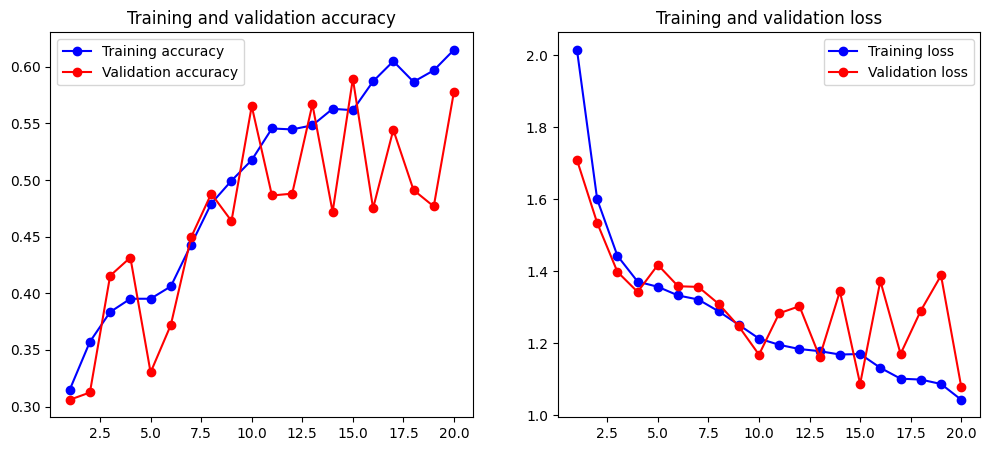

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(validation_generator, steps=50)
print('Test accuracy:', test_acc)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5774 - loss: 1.0805
Test accuracy: 0.5780998468399048


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
img = image.load_img('/content/Data/pituitary_tumor/P_107.jpg', target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create batch dimension
img_array /= 255.0  # Normalize pixel values

# Make prediction
prediction = model.predict(img_array)

# Define the class names corresponding to the model output indices
# Adjust the list to reflect the actual class order used during training
class_names = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

# Get the index of the highest probability
predicted_index = np.argmax(prediction)
predicted_class = class_names[predicted_index]

print("Prediction:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction: pituitary_tumor
